#  Taylor problem 5.50 

last revised: 21-Jan-2019 by Dick Furnstahl [furnstahl.1@osu.edu]


Here we are exploring the Fourier series for a waveform defined to be odd about the origin, so $f(-t) = -f(t)$, with period $\tau$.  That means that the integrand for the $a_m$ coefficients is odd and so all of the corresponding integrals vanish.  

The particular wave of interest here is a sawtooth, such that in the interval $-\tau/2 \leq t \leq \tau/2$, the function takes the form:

$\newcommand{\fmax}{f_{\textrm{max}}}$
$\begin{align}
  f(t) = \left\{ \begin{array}{ll}
                   \fmax(t/\tau) & t < 0 \\
                   \fmax(t/\tau) & t > 0  
                 \end{array}
                   \right.
\end{align}$

(we wrote it this way so it looks like the function for problem 5.49).


As already note, the $a_m$ coefficients are zero, so we only calculate the $b_m$ coefficients.  Here $\omega \equiv 2\pi/\tau$.  The result is:


$\begin{align}
  b_m = \frac{2}{\tau} \int_{-\tau/2}^{\tau/2} \sin(m\omega t) f(t)\, dt = 
     % 2 \fmax \int_0^1 \sin(m\pi t) t\, dt 
    %  &= - \frac{2\fmax}{(m\pi)^2)}\left[\sin(m\pi t)\right]^1_0 \\
     % =
      \left\{ 
      \begin{array}{ll}
        -\frac{ \fmax}{m\pi} & [m\ \mbox{even}] \\
        \frac{ \fmax}{m\pi} & [m\ \mbox{odd}]
      \end{array}
      \right.
\end{align}$

Note that the coefficients are independent of $\tau$.  Is this a general result?

## Define the functions we'll need

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

We start by defining a function for the sawtooth wave at any $t$.  The definition here is for a scalar function.  That is, it won't work to call it with $t$ and array of time points, unlike other functions we have defined.  It is possible to make it work, but then the function will be much less clear.  When we need to evaluate it for all elements of an array, we will use the construction: `np.array([sawtooth(t) for t in t_pts])` for the array `t_pts`.

In [2]:
def sawtooth(t, tau, f_max=1):
    """Returns the sawtooth wave of amplitude f_max and odd about the 
        origin at time t.  The period is tau.  It is defined as a scalar 
        function (i.e., only one value of t can be passed at a time).  
    """
    if np.floor(t) % 2 == 0:
        t_adjust = t - np.floor(t)
        return t_adjust / tau
    else:
        t_adjust = t - (np.floor(t) + 1)
        return t_adjust / tau
    

Now a function that creates an array of Fourier coefficients for the sawtooth wave up to order N_max.

In [3]:
def sawtooth_coeffs_by_hand(N_max, tau=2., f_max=1.):
    """Fourier coefficients calculated by hand and loaded into an array.
        Note that these are independent of tau, but we pass it for 
        consistency with other functions.
    """
    coeffs_array = [(0., 0.)]   # a_0 and b_0
    for n in np.arange(1, N_max, 1):
        if (n % 2) == 0:    # for even n
            b_n = -f_max / (n * np.pi)
        else:          # for odd n 
            b_n = f_max / (n * np.pi)
        a_n = 0.
        coeffs_array.append((a_n, b_n))
    
    return np.array(coeffs_array)  # convert to a numpy array

We would like a general way to construct the away of Fourier coefficients given any periodic function.  Our first pass at that uses a class definition and the scipy integration function quad. 

In [4]:
class FourierSeries():
    """
    Fourier series class finds the coefficients in a Fourier series with
    period tau up to a specified order.
    Assume these imports:
        from scipy.integrate import quad
        import numpy as np
    """
    def __init__(self,
                 function,
                 tau=2,
                 N_max=10
                ):
        self.function = function
        self.tau = tau
        self.omega = 2. * np.pi / tau    
        self.N_max = N_max
        # add something to quit if Nmax < 0 or not an integer (try and except)

    def a0_calc(self):
        """Calculate the constant Fourier coefficient by integration"""
        answer, error = quad(self.function, -tau/2., tau/2., args=(tau,))
        return (1./self.tau) * answer
    
    def an_integrand(self, t, n):
        """Integrand for the nth cosine coefficient"""
        return self.function(t, tau) * np.cos(n * self.omega * t)
    
    def an_calc(self, n):
        """Calculate the nth cosine coefficient (n > 0)"""
        # note comma after n in args
        answer, error = quad(self.an_integrand, -tau/2., tau/2., args=(n,))  
        return (2./self.tau) * answer
    
    def bn_integrand(self, t, n):
        """Integrand for the nth cosine coefficient"""
        return self.function(t, tau) * np.sin(n * self.omega * t)
    
    def bn_calc(self, n):
        """Calculate the nth cosine coefficient (n > 0)"""
        answer, error = quad(self.bn_integrand, -tau/2., tau/2., args=(n,))  
        return (2./self.tau) * answer
        
    def coeffs_upto_Nmax(self):
        """Calculate the Fourier series up to Nmax"""
        # first generate the coefficient
        coeffs_array = [(self.a0_calc(), 0)]   # a_0 and b_0
        
        for n in np.arange(1, N_max, 1):
            a_n = self.an_calc(n)
            b_n = self.bn_calc(n)
            coeffs_array.append((a_n, b_n))  # append a tuple of coefficients
    
        return np.array(coeffs_array)  # convert to a numpy array  
    

Finally, we need a function that can take as input an array of t values and an array of Fourier coefficients and return the function at those t values with terms up to order N_max. 

In [5]:

def Fourier_reconstruct(t_pts, coeffs_array, tau, N_max):
    """Sum up the Fourier series up to n = N_max terms."""
    omega = 2. * np.pi / tau
    result = 0.
    # iterate over coefficients but only up to N_max
    for n, (a,b) in enumerate(coeffs_array[:N_max+1]):  
        result = result + a * np.cos(n * omega * t_pts) \
                        + b * np.sin(n * omega * t_pts)
    return result    

## Problem 5.50

Ok, now we can do problem 5.49.  Calculate the coefficients both ways.

In [6]:
N_max = 20
tau = 2.
f_max = 1.
coeffs_by_hand = sawtooth_coeffs_by_hand(N_max, tau, f_max)

fs = FourierSeries(sawtooth, tau, N_max)
coeffs_by_quad = fs.coeffs_upto_Nmax()

Let's check that the exact and numerical calculation of the coefficients agree.  

(Note the space in the formats, e.g., `{a1: .6f}`.  This means to leave an extra space for a positive number so that it aligns at the decimal point with negative numbers.)

In [7]:
print(' n   a_exact     a_quad      b_exact     b_quad')
for n, ((a1,b1), (a2,b2)) in enumerate(zip(coeffs_by_hand,
                                           coeffs_by_quad)):
    print(f'{n:2d}  {a1: .6f}  {a2: .6f}    {b1: .6f}  {b2: .6f}')

 n   a_exact     a_quad      b_exact     b_quad
 0   0.000000   0.000000     0.000000   0.000000
 1   0.000000   0.000000     0.318310   0.318310
 2   0.000000   0.000000    -0.159155  -0.159155
 3   0.000000   0.000000     0.106103   0.106103
 4   0.000000   0.000000    -0.079577  -0.079577
 5   0.000000   0.000000     0.063662   0.063662
 6   0.000000   0.000000    -0.053052  -0.053052
 7   0.000000   0.000000     0.045473   0.045473
 8   0.000000   0.000000    -0.039789  -0.039789
 9   0.000000   0.000000     0.035368   0.035368
10   0.000000   0.000000    -0.031831  -0.031831
11   0.000000   0.000000     0.028937   0.028937
12   0.000000   0.000000    -0.026526  -0.026526
13   0.000000   0.000000     0.024485   0.024485
14   0.000000   0.000000    -0.022736  -0.022736
15   0.000000   0.000000     0.021221   0.021221
16   0.000000   0.000000    -0.019894  -0.019894
17   0.000000   0.000000     0.018724   0.018724
18   0.000000   0.000000    -0.017684  -0.017684
19   0.000000   0.000

Make the comparison plot requested: N_max = 2 vs. N_max = 6.

In [8]:
t_pts = np.arange(-2., 6., .01)
f_pts_2 = Fourier_reconstruct(t_pts, coeffs_by_quad, tau, 2)
f_pts_6 = Fourier_reconstruct(t_pts, coeffs_by_quad, tau, 6)

# Python way to evaluate the sawtooth function at an array of points:
#   * np.array creates a numpy array;
#   * note the []s around the inner statement;
#   * sawtooth(t) for t in t_pts  
#       means step through each element of t_pts, call it t, and
#       evaluate sawtooth at that t.
#   * This is called a list comprehension.  There are more compact ways,
#      but this is clear and easy to debug.
sawtooth_t_pts = np.array([sawtooth(t, tau, f_max) for t in t_pts])

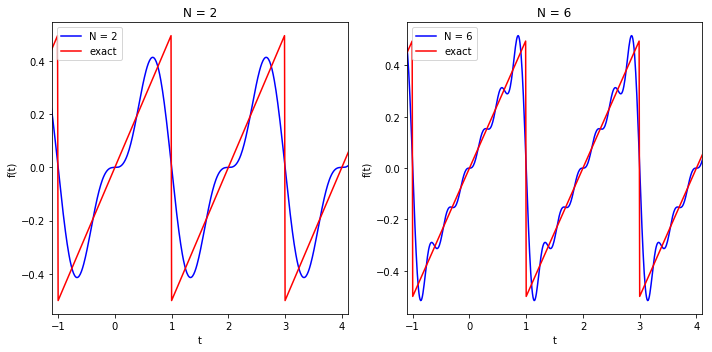

In [9]:

fig_1 = plt.figure(figsize=(10,5))
ax_1 = fig_1.add_subplot(1,2,1)
ax_1.plot(t_pts, f_pts_2, label='N = 2', color='blue')
ax_1.plot(t_pts, sawtooth_t_pts, label='exact', color='red')
ax_1.set_xlim(-1.1,4.1)
ax_1.set_xlabel('t')
ax_1.set_ylabel('f(t)')
ax_1.set_title('N = 2')
ax_1.legend()

ax_2 = fig_1.add_subplot(1,2,2)
ax_2.plot(t_pts, f_pts_6, label='N = 6', color='blue')
ax_2.plot(t_pts, sawtooth_t_pts, label='exact', color='red')
ax_2.set_xlim(-1.1,4.1)
ax_2.set_xlabel('t')
ax_2.set_ylabel('f(t)')
ax_2.set_title('N = 6')
ax_2.legend();

fig_1.tight_layout()
fig_1.savefig('problem_5.50.png')